In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
st=time.time()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense
import matplotlib.pyplot as plt

import numpy as np
from skimage import transform


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
from glob import glob
from tqdm.auto import tqdm
#from coreLib.utils import *
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import cv2
import itertools
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
batch_size = 32
img_height = 99
img_width = 99

In [ ]:
train_path = '/content/drive/MyDrive/SS_splitted/train'
valid_path = '/content/drive/MyDrive/SS_splitted/valid'
test_path =  '/content/drive/MyDrive/SS_splitted/test'

In [ ]:
train_dataset = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255).flow_from_directory(directory=train_path, target_size=(99, 99), classes=["CuttingCaterpillar", "CuttingWeevil", "DieBack", "Healthy", "WhiteFly","Yellow"])

test_dataset = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255).flow_from_directory(directory=test_path, target_size=(99, 99), classes=["CuttingCaterpillar", "CuttingWeevil", "DieBack", "Healthy", "WhiteFly","Yellow"])

valid_dataset = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255).flow_from_directory(directory=valid_path, target_size=(99, 99), classes=["CuttingCaterpillar", "CuttingWeevil", "DieBack", "Healthy", "WhiteFly","Yellow"])


Found 2838 images belonging to 6 classes.
Found 321 images belonging to 6 classes.
Found 518 images belonging to 6 classes.


X,Y split generation

In [ ]:
labels = ["CuttingCaterpillar", "CuttingWeevil", "DieBack", "Healthy", "WhiteFly","Yellow"]
img_size = 99
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data_dir = get_data("/content/drive/MyDrive/Soursop")

<ipython-input-7-a8fdab37b170>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
X = []
Y = []


for feature, label in data_dir:
  X.append(feature)
  Y.append(label)
X = np.array(X) / 255
X.reshape(-1, img_size, img_size, 1)
Y = np.array(Y)

In [ ]:
print(X.shape)

(3844, 99, 99, 3)


In [ ]:
# split with a stratified sampling
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=42)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.18, random_state= 8) # 0.25 x 0.8 = 0.2

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (2836, 99, 99, 3) - y_train shape: (2836,)
x_val shape: (623, 99, 99, 3) - y_val shape: (623,)
x_test shape: (385, 99, 99, 3) - y_test shape: (385,)


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
nb_train_data = 2836
nb_eval_data = 628

In [ ]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = nb_train_data//32
EVAL_STEPS      = nb_eval_data//32
print(STEPS_PER_EPOCH,EVAL_STEPS)

88 19


In [ ]:
from tensorflow.keras.layers import Dense, GaussianNoise

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(99,99,3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.25))

model.add(Flatten())


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

#model.add(GaussianNoise(0.001))'''

In [ ]:
# reduces learning rate on plateau
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7)



# stop learining as metric on validatopn stop increasing
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,
                                                  verbose=1,
                                                  mode = 'auto')

callbacks = [lr_reducer,early_stopping ]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 97, 97, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 128)       36992     
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 47, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                   

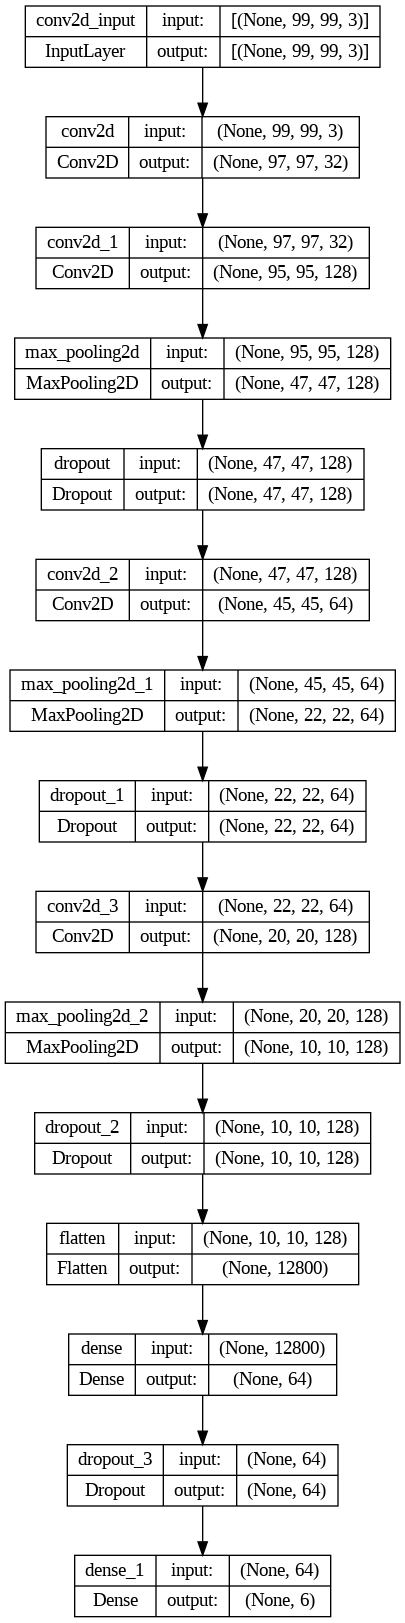

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,name="Adam",beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False),
  metrics=['accuracy']
)

In [ ]:
# fit the model
ae_history = model.fit(
  x=x_train, y=y_train, validation_data=(x_val, y_val),
  epochs=20,
  callbacks=callbacks,
  batch_size=BATCH_SIZE,shuffle=True)

Epoch 1/20
89/89 [==============================] - 12s 68ms/step - loss: 1.4798 - accuracy: 0.3868 - val_loss: 0.9457 - val_accuracy: 0.6838 - lr: 0.0010
Epoch 2/20
89/89 [==============================] - 5s 55ms/step - loss: 0.7121 - accuracy: 0.7250 - val_loss: 0.4818 - val_accuracy: 0.8154 - lr: 0.0010
Epoch 3/20
89/89 [==============================] - 5s 53ms/step - loss: 0.4901 - accuracy: 0.8068 - val_loss: 0.2059 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 4/20
89/89 [==============================] - 5s 53ms/step - loss: 0.3754 - accuracy: 0.8456 - val_loss: 0.2096 - val_accuracy: 0.9230 - lr: 0.0010
Epoch 5/20
89/89 [==============================] - 5s 55ms/step - loss: 0.3245 - accuracy: 0.8755 - val_loss: 0.1428 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 6/20
89/89 [==============================] - 5s 54ms/step - loss: 0.2487 - accuracy: 0.8988 - val_loss: 0.0875 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 7/20
89/89 [==============================] - 5s 54ms/step - loss: 0.

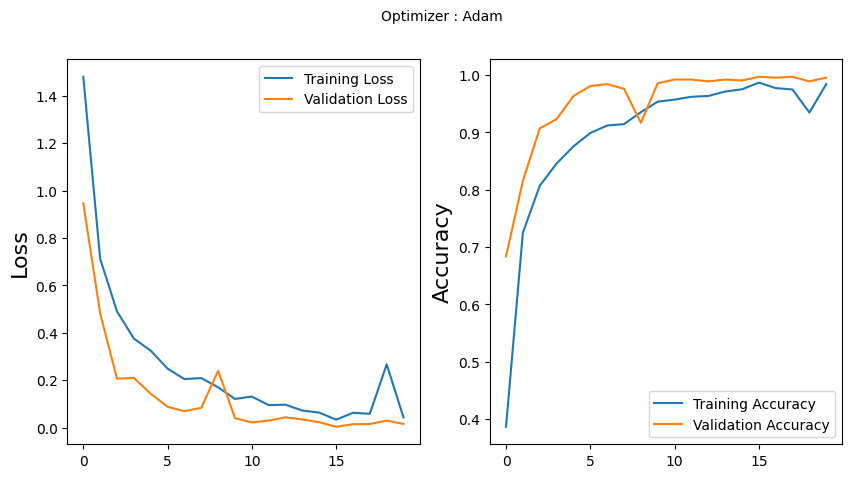

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(ae_history.history['loss'], label='Training Loss')
plt.plot(ae_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(ae_history.history['accuracy'], label='Training Accuracy')
plt.plot(ae_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#history = model.fit(x=train_dataset, validation_data= valid_dataset, epochs=1)
history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=1)

89/89 [==============================] - 5s 55ms/step - loss: 0.0229 - accuracy: 0.9912 - val_loss: 0.1827 - val_accuracy: 0.9358


In [ ]:
cnn_predictions = model.predict(x_val)
cnn_y_pred = [np.argmax(probas) for probas in cnn_predictions]

20/20 [==============================] - 0s 11ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 89   0   0   0   0   1]
 [  2 103   0   0   0   0]
 [  0   0  96   0   0   0]
 [ 36   0   0  79   0   0]
 [  0   0   0   1 111   0]
 [  0   0   0   0   0 105]]


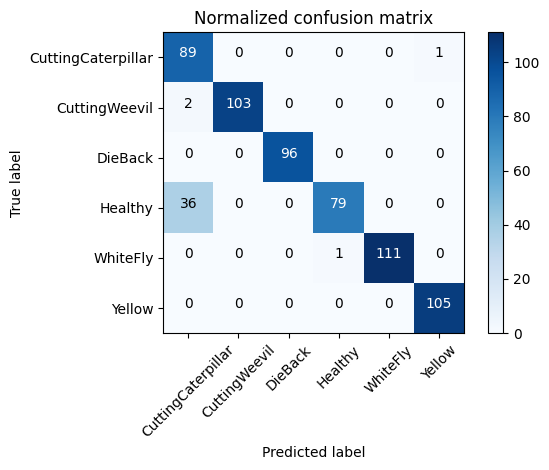

In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_val, cnn_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0", "1", "2", "3", "4","5"], title='Normalized confusion matrix')
plt.show()

In [ ]:
report=classification_report(y_val, cnn_y_pred, target_names=["CuttingCaterpillar", "CuttingWeevil", "DieBack", "Healthy", "WhiteFly","Yellow"])
print(report)

                    precision    recall  f1-score   support

CuttingCaterpillar       0.70      0.99      0.82        90
     CuttingWeevil       1.00      0.98      0.99       105
           DieBack       1.00      1.00      1.00        96
           Healthy       0.99      0.69      0.81       115
          WhiteFly       1.00      0.99      1.00       112
            Yellow       0.99      1.00      1.00       105

          accuracy                           0.94       623
         macro avg       0.95      0.94      0.94       623
      weighted avg       0.95      0.94      0.94       623



In [ ]:
cnn_predictions = model.predict(x_test)
cnn_y_pred = [np.argmax(probas) for probas in cnn_predictions]

13/13 [==============================] - 0s 17ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[64  0  0  0  0  0]
 [ 1 63  0  0  0  0]
 [ 0  0 65  0  0  0]
 [26  0  0 40  0  0]
 [ 0  0  0  0 64  0]
 [ 0  0  0  0  0 62]]


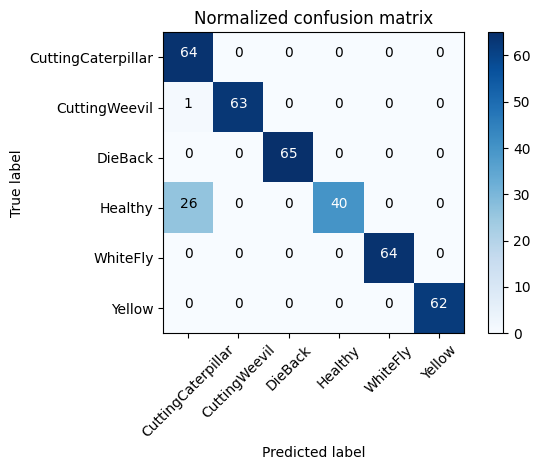

In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, cnn_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0", "1", "2", "3", "4","5"], title='Normalized confusion matrix')
plt.show()

In [ ]:
report=classification_report(y_test, cnn_y_pred, target_names=["CuttingCaterpillar", "CuttingWeevil", "DieBack", "Healthy", "WhiteFly","Yellow"])
print(report)

                    precision    recall  f1-score   support

CuttingCaterpillar       0.70      1.00      0.83        64
     CuttingWeevil       1.00      0.98      0.99        64
           DieBack       1.00      1.00      1.00        65
           Healthy       1.00      0.61      0.75        66
          WhiteFly       1.00      1.00      1.00        64
            Yellow       1.00      1.00      1.00        62

          accuracy                           0.93       385
         macro avg       0.95      0.93      0.93       385
      weighted avg       0.95      0.93      0.93       385



In [ ]:
et=time.time()
et=et-st
print(f"Execution time:{et}s")

Execution time:193.7517955303192s
